In [ ]:
#Code to compute the internal energy change during encounter along eccentric orbit: adiabatic correction is included.

#Computes and plots \Delta E_{int}/|E_{bind}| (E_bind=binding energy of the subject) 
#and \Delta E_{int}(Gnedin et al. 99)/\Delta E_{int}(non-perturbative) vs eccentricity for given orbital energy

In [72]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import random
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.ticker as ticker
from matplotlib.patches import BoxStyle
from scipy import integrate
from scipy import optimize
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
from scipy.special import erf as errorfunc
from scipy.special import gamma, factorial
from scipy.signal import argrelextrema 
from matplotlib import cm
from numpy import linalg
import time
import os
import h5py
import string
from eccentric_functions import *

#-----------------------------------------------------------------



In [10]:
#-------Input parameters-------

Rc=1                                   #Truncation radius 1
x=100                                  #Truncation radius 2/ Truncation radius 1
NR=100                                 #No of points in R(theta)

rp=1e2                                 #Perturber scale radius in units of rs
mass_ratio=1e-3                        #Subject mass Ms/Perturber mass Mp

perturber_flag=1                       #perturber_flag: 1: Hernquist sphere, 2: NFW, 3: Plummer sphere, 4: Isochrone
subject_flag=2                         #subject_flag: 1: Plummer sphere, 2: Hernquist sphere, 3: NFW
if (subject_flag==3):
    c1=Rc                              #NFW concentration
    c2=x*Rc
else:
    c1=np.nan
    c2=np.nan
    
    
Ne=40                                  #No of points in eccentricity e; Default: 100
emin=0.001                             #Minimum eccentricity
emax=0.999                             #Maximum eccentricity

E0=-0.7                                #Orbital energy (bound: <0) Min=-1 for perturber_flag=1,2,3 but -0.5 for 4

adcorr_flag=1                          #Adiabatic correction: 1- on, 0- off

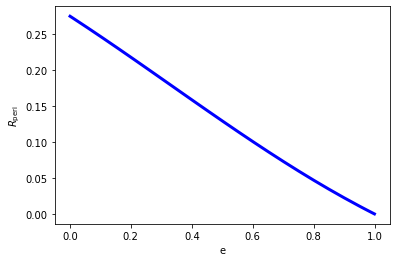

In [11]:
#-------Orbit-------

#alpha=1/R_peri

e0=np.linspace(emin,0.009,(int)(Ne/4))
e1=np.linspace(0.01,0.949,(int)(Ne/2))
e2=np.linspace(0.95,emax,(int)(Ne/4))
e=np.array(e0.tolist()+e1.tolist()+e2.tolist())
#e=np.logspace(-1,np.log10(0.95),num=Ne)
alpha=np.zeros(Ne)

for i in range(Ne):
    alpha[i]=ALPHA(E0,e[i],perturber_flag)          #alpha=1/R_peri

plt.plot(e,1/alpha,lw=3,color='b')
plt.xlabel('e')
plt.ylabel('$R_{\mathrm{peri}}$')
plt.show()

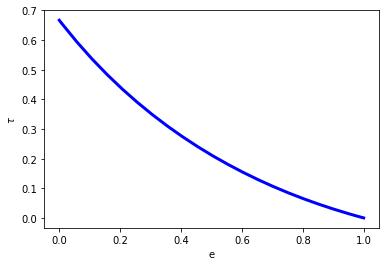

In [12]:
#-------Orbit-------

#Encounter time

TP=np.zeros(Ne)                                      #Encounter time
for i in range(Ne):
    Jp=jp(alpha[i],e[i],perturber_flag)
    TP[i]=1/(alpha[i]**2*Jp)

plt.plot(e,TP,lw=3,color='b')
plt.xlabel('e')
plt.ylabel('$\\tau$')
plt.show()

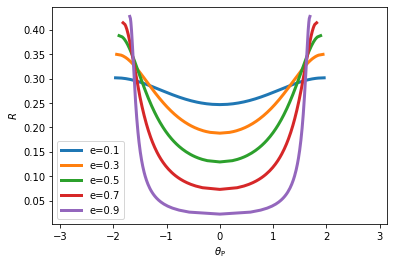

In [13]:
#-------Orbit-------

#R vs \theta_P                  #R=distance of perturber COM from subject COM, \theta_P=angle subtended by perturber COM
                                #with the pericenter, i.e. \theta_P=0 at R=R_peri

ecc=np.linspace(0.1,0.9,5)
Necc=len(ecc)
alpha_test=np.zeros(Necc)
for i in range(Necc):
    alpha_test[i]=ALPHA(E0,ecc[i],perturber_flag)

THETAP_test=np.zeros((len(ecc),2*NR-1))
RP_test=np.zeros((len(ecc),2*NR-1))

for i in range(Necc):
    THETAP_test[i]=orbit(alpha_test[i],ecc[i],NR,perturber_flag)[0]
    RP_test[i]=orbit(alpha_test[i],ecc[i],NR,perturber_flag)[1]

for i in range(Necc):
    plt.plot(THETAP_test[i],RP_test[i],lw=3,label='e=%.1f' %(ecc[i]))
    plt.xlim([-np.pi,np.pi])
plt.xlabel('$\\theta_{\mathrm{P}}$')
plt.ylabel('$R$')
plt.legend(loc=3)

plt.show()

In [14]:
#-------Calculation of internal energy change: General and Gnedin et al. 1999-------

DELVCM_trunc1=np.zeros(Ne)                  #COM velocity (Truncation radius 1)
DELEINT_trunc1=np.zeros(Ne)                 #General internal energy change (Truncation radius 1)
DELEINT_tidal1=np.zeros(Ne)                 #Gnedin et al. 1999 internal energy change (Truncation radius 1)

DELVCM_trunc2=np.zeros(Ne)                  #COM velocity (Truncation radius 2)
DELEINT_trunc2=np.zeros(Ne)                 #General internal energy change (Truncation radius 2)
DELEINT_tidal2=np.zeros(Ne)                 #Gnedin et al. 1999 internal energy change (Truncation radius 2)


if (subject_flag==3):
    xM1=Menc(Rc,subject_flag)/(np.log(1+c1)-c1/(1+c1))
    xM2=Menc(x*Rc,subject_flag)/(np.log(1+c2)-c2/(1+c2))
else:
    xM1=Menc(Rc,subject_flag)
    xM2=Menc(x*Rc,subject_flag)
Rhalf1=half_mass_radius(xM1,c1,subject_flag)  #Half mass radius (Truncation radius 1=Rc)
Rhalf2=half_mass_radius(xM2,c2,subject_flag)   #Half mass radius (Truncation radius 2=x*Rc)


Mtrunc1=Menc(Rc,subject_flag)               #Mass (Truncation radius 1=Rc)
Mtrunc2=Menc(x*Rc,subject_flag)             #Mass (Truncation radius 2=x*Rc)

tp=Tp0(E0,rp,perturber_flag)                   #Radial crossing time

fp=open("eccentric_encounter_perturber%d_subject%d_rp_%.3f_E0_%.1f_adcorr_trunc.dat" %(perturber_flag,subject_flag,rp,E0), "w")


start=time.time()

for i in range(Ne):
    
    THETAP=orbit(alpha[i],e[i],NR,perturber_flag)[0]
    RP=orbit(alpha[i],e[i],NR,perturber_flag)[1]
    
    DELVCM_trunc1[i]=delvcm(alpha[i],e[i],THETAP,RP,Rc,rp,NR,perturber_flag,subject_flag)/rp**2
    DELEINT_trunc1[i]=rp**4*delEint(alpha[i],e[i],THETAP,RP,DELVCM_trunc1[i],Rc,Rhalf1,Mtrunc1,mass_ratio,rp,tp,adcorr_flag,perturber_flag,subject_flag)
    
    DELVCM_trunc2[i]=delvcm(alpha[i],e[i],THETAP,RP,x*Rc,rp,NR,perturber_flag,subject_flag)/rp**2
    DELEINT_trunc2[i]=rp**4*delEint(alpha[i],e[i],THETAP,RP,DELVCM_trunc2[i],x*Rc,Rhalf2,Mtrunc2,mass_ratio,rp,tp,adcorr_flag,perturber_flag,subject_flag)
    
    DELEINT_tidal1[i]=(1/rp**2)*delEint_tidal(alpha[i],e[i],THETAP,RP,Rc,Rhalf1,Mtrunc1,mass_ratio,rp,tp,adcorr_flag,perturber_flag,subject_flag)
    DELEINT_tidal2[i]=(1/rp**2)*delEint_tidal(alpha[i],e[i],THETAP,RP,x*Rc,Rhalf2,Mtrunc2,mass_ratio,rp,tp,adcorr_flag,perturber_flag,subject_flag)
    
    fp.write("%.10e\t%.10e\t%.10e\t%.10e\t%.10e\n" %(e[i],DELEINT_trunc1[i],DELEINT_tidal1[i],DELEINT_trunc2[i],DELEINT_tidal2[i]))
    
    end=time.time()
    
    print ("%d\tTime taken: %f s\n" %(i,end-start))
    
fp.close()

/home/uddipan/Documents/PhD_Yale/thesis/impulsive_encounter/codes/eccentric_functions.py:201: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I1=integrate.quad(theta_integrand1,0,alpha*(e/(1+e)),args=(alpha,e,perturber_flag,))[0]
/home/uddipan/Documents/PhD_Yale/thesis/impulsive_encounter/codes/eccentric_functions.py:202: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I2=integrate.quad(theta_integrand2,z2,alpha*(e/(1+e)),args=(alpha,e,perturber_flag,))[0]


0	Time taken: 19.755022 s

1	Time taken: 39.337286 s

2	Time taken: 59.168365 s

3	Time taken: 79.026561 s

4	Time taken: 99.731651 s

5	Time taken: 121.558917 s

6	Time taken: 143.950863 s

7	Time taken: 165.900791 s

8	Time taken: 186.589941 s

9	Time taken: 208.407198 s

10	Time taken: 230.501622 s

11	Time taken: 251.815686 s

12	Time taken: 270.883359 s

13	Time taken: 289.933581 s

14	Time taken: 308.666952 s

15	Time taken: 318.326288 s

16	Time taken: 327.880876 s

17	Time taken: 337.496935 s

18	Time taken: 347.174045 s

19	Time taken: 356.878540 s

20	Time taken: 366.340296 s

21	Time taken: 375.766979 s

22	Time taken: 394.133429 s

23	Time taken: 412.464252 s

24	Time taken: 431.033002 s

25	Time taken: 449.799896 s

26	Time taken: 459.327671 s

27	Time taken: 477.884673 s

28	Time taken: 496.455742 s

29	Time taken: 514.968781 s

30	Time taken: 533.278330 s

31	Time taken: 551.659385 s

32	Time taken: 561.330829 s

33	Time taken: 571.027470 s

34	Time taken: 580.657159 s



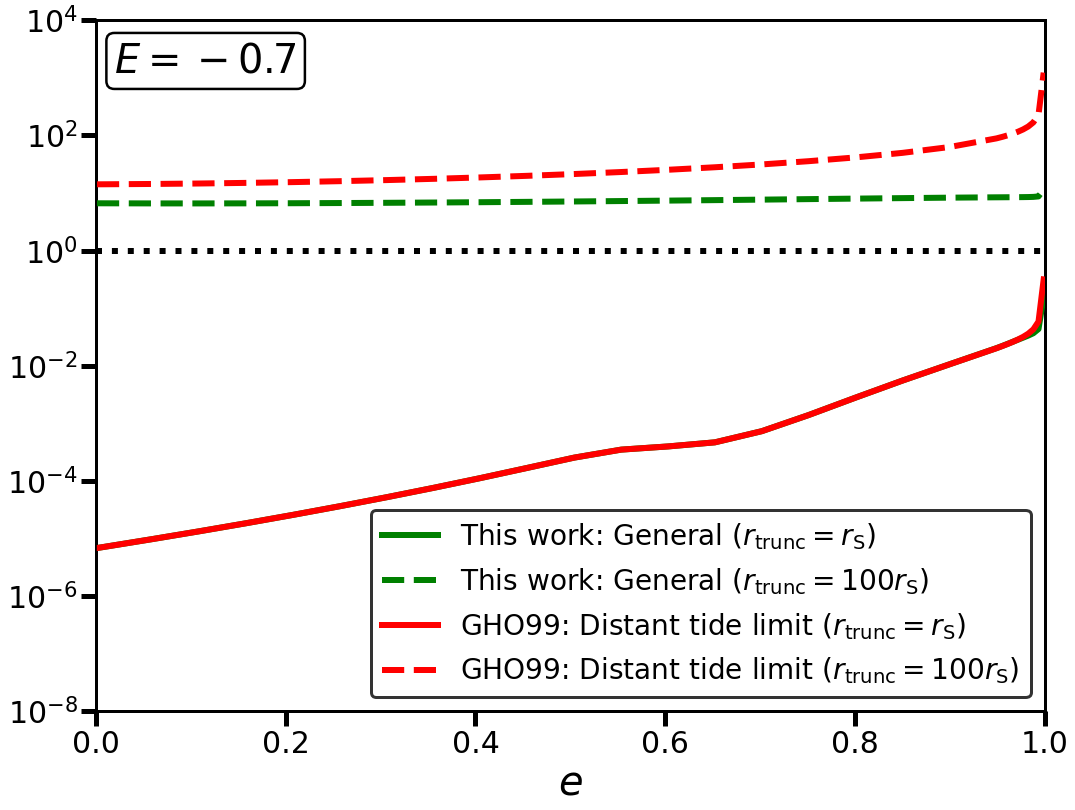

In [15]:
#-------Plots-------

#Delta E_int / |E_bind|

fig,ax=plt.subplots(figsize=(17,12))
plt.subplots_adjust(top=0.95,bottom=0.15)

ax.plot(e,(24/(4*mass_ratio*rp))*DELEINT_trunc1,color='g',lw=6,label='This work: General $(r_{\mathrm{trunc}}=r_{\mathrm{S}})$')
ax.plot(e,(12/(mass_ratio*rp))*DELEINT_trunc2,ls='--',color='g',lw=6,label='This work: General $(r_{\mathrm{trunc}}=100r_{\mathrm{S}})$')

ax.plot(e,(24/(4*mass_ratio*rp))*DELEINT_tidal1,color='r',lw=6,label='GHO99: Distant tide limit $(r_{\mathrm{trunc}}=r_{\mathrm{S}})$')
ax.plot(e,(12/(mass_ratio*rp))*DELEINT_tidal2,ls='--',color='r',lw=6,label='GHO99: Distant tide limit $(r_{\mathrm{trunc}}=100r_{\mathrm{S}})$')


ax.set_yscale('log')

ax.tick_params(which='major', width=5, length=15, color='k')
ax.tick_params(axis='y',which='minor', width=4, length=10, color='k')

ax.set_xticks(np.linspace(0,1,6))
ax.set_yticks(np.logspace(np.log10(1e-8),np.log10(1e4),num=7))
#ax.set_yticks([],[])
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xlim([0,1])
ax.set_ylim([1e-8,1e4])

ax.tick_params(labelsize=30)
ax.set_xlabel('$e$',fontsize=40)
#ax.set_ylabel('$\Delta E_{\mathrm{int}}\,/\,\left|E_{\mathrm{bind}}\\right|$',fontsize=40)
leg=ax.legend(loc=4,fontsize=28)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth('3.0')
ax.patch.set_edgecolor('k')  
ax.patch.set_linewidth('3')
ax.axhline(y=1e0,color='k',ls=':',lw=6)

fig.text(0.14, 0.89, '$E=%.1f$' %(E0), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', linewidth=2.5, pad=0.2, alpha=1), fontsize=40)

plt.savefig('deltaEint_vs_e_perturber%d_subject%d_E%.1f_massratio_%.1f_rp_%.1f_adcorr%d.jpeg' %(perturber_flag,subject_flag,E0,1.0/mass_ratio,rp,adcorr_flag))

plt.show()

/home/uddipan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


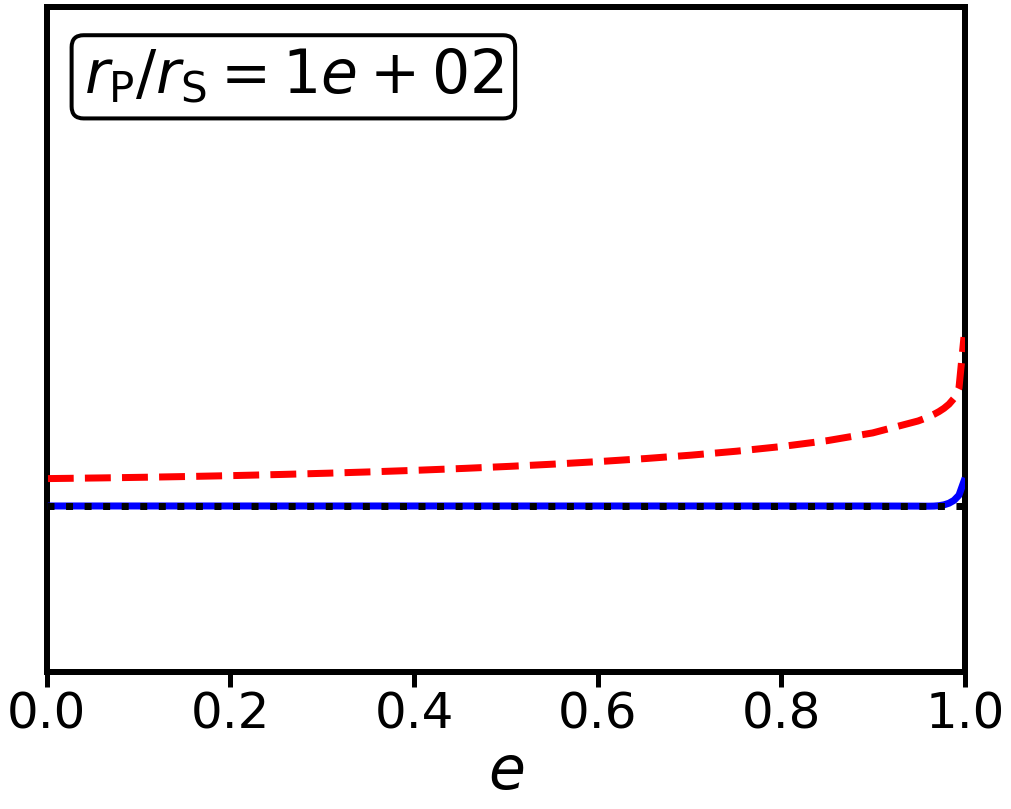

In [16]:
#Delta E_int_GHO99 / Delta E_int_general

fig,ax=plt.subplots(figsize=(17,12))
plt.subplots_adjust(top=0.95,bottom=0.18,left=0.2,right=0.95)

ax.plot(e,(1/DELEINT_trunc1)*DELEINT_tidal1,color='b',lw=7,label='$r_{\mathrm{trunc}}=r_{\mathrm{S}}$')
ax.plot(e,(1/DELEINT_trunc2)*DELEINT_tidal2,ls='--',color='r',lw=7,label='$r_{\mathrm{trunc}}=100r_{\mathrm{S}}$')

ax.set_yscale('log')

ax.tick_params(which='major', width=5, length=15, color='k')
#ax.tick_params(axis='y',which='minor', width=4, length=10, color='k')

ax.set_xticks(np.linspace(0,1,6))
#ax.set_yticks(np.logspace(np.log10(1e-2),np.log10(1e6),num=5))
ax.set_yticks([],[])
#locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xlim([0,1])
ax.set_ylim([1e-2,1e6])
ax.tick_params(labelsize=50)

ax.set_xlabel('$e$',fontsize=60)
#ax.set_ylabel('$\Delta E_{\mathrm{int}}(\mathrm{GHO}99)\,/\,\Delta E_{\mathrm{int}}$',fontsize=60)
#leg=ax.legend(loc=4,ncol=2,fontsize=42)
#leg.get_frame().set_edgecolor('k')
#leg.get_frame().set_linewidth('5.0')
ax.patch.set_edgecolor('k')  
ax.patch.set_linewidth('6')
ax.axhline(y=1e0,color='k',ls=':',lw=7)

fig.text(0.23, 0.85, '$r_{\mathrm{P}}/r_{\mathrm{S}}=%.0e$' %(rp), bbox=dict(boxstyle='round', facecolor='none', edgecolor='black', linewidth=4, pad=0.2, alpha=1), fontsize=60)

plt.savefig('deltaEintratio_vs_e_perturber%d_subject%d_E%.1f_massratio_%.1f_rp_%.1f_adcorr%d.jpeg' %(perturber_flag,subject_flag,E0,1.0/mass_ratio,rp,adcorr_flag))

plt.show()